In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import numpy as np
from rdkit.Chem import Draw
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import precision_recall_curve
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error

RDKit WARNING: [10:06:46] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
data = pd.read_csv('LXRb_ch25_curated_DW_2.csv')
# copy raw data
data_new = data.copy()
data_new["Molecule"] = [Chem.MolFromSmiles(mol) for mol in data["smiles"]]

#colmun['Molecule'] invert to binary systems
data_new['bin'] = [np.array(AllChem.GetMorganFingerprintAsBitVect(i,2, nBits=1024)) for i in data_new['Molecule']]


In [4]:
data[:5]

smiles      chembl_id   potency  \
0   Cc1cc2c(cc1C(=C)c3ccc(cc3)C(=O)O)C(C)(C)CCC2(C)C     CHEMBL1023   434.000   
1  CCc1nc2c(cccc2nc1c3ccc(cc3)c4cccc(c4)S(=O)(=O)...  CHEMBL1089232  2805.000   
2  CS(=O)(=O)c1cccc(c1)c2ccc(CN(Cc3ccc(F)cc3Cl)S(...  CHEMBL1091034     3.162   
3  Cc1ccccc1S(=O)(=O)N(Cc2ccc(cc2)c3cccc(c3)S(=O)...  CHEMBL1091976     3.162   
4  Cn1cnc(c1)S(=O)(=O)N(Cc2ccc(cc2)c3cccc(c3)S(=O...  CHEMBL1092952    79.430   

      pec50  category  
0  6.362510    active  
1  5.569777  inactive  
2  8.500038    active  
3  8.500038    active  
4  7.100015    active

In [5]:
data_new.pec50.min()

3.9023956711255896

In [6]:
data_new.pec50.max()

9.0

In [102]:
##### classifikation model change thre and than i compare date for diferent thre
#this model predict active/inactive compounds
#case1
def classification_model(thre):
    random_state = 20


    #add new columns, number of columns
    data_new['number'] = data_new['chembl_id'].rank(method='min')
    lab_enc = preprocessing.LabelEncoder()
    data_new['number']= lab_enc.fit_transform(data_new['number'])
    data_new['category_new'] = np.where(data_new['pec50']>=thre, 1, 0)

    #divided date for two sets: train and test
    train, test = train_test_split(data_new, test_size = 0.25, random_state = random_state)
    train, test = train.copy(), test.copy()
    x_train = np.asarray([x for x in train['bin']])
    x_test = np.asarray([x for x in test['bin']]) 
    y_train = np.asarray([y for y in train['category_new']])
    y_test = np.asarray([y for y in test['category_new']])

    #RandomForesrClassifier
    crf = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
    crf.fit(x_train,y_train)
    
    # prediction on test set
    crf_predict = crf.predict(x_test)

    #CLassification:
       #accuracy, spe, sen, MCC,
        #confusion matrices (true positive, true negative, false positive, false negative (TP, TN, FP, FN))
    
    #confusion_matrix
    #print("Confusion_matrix for test set:")

    conf_matrix = confusion_matrix(y_test, crf_predict)
    #print(conf_matrix)
    TN, FP, FN, TP = conf_matrix.ravel()
    d = {' ': ['actual+', 'actual-'], 'predicted+':[TP, FN], 'predicted-':[FP, TN]}
    df = pd.DataFrame(data=d)
    #print("\n")
    #print(df)
    #print("\n")

    #Accuracy
    #print("Accuracy:",metrics.accuracy_score(y_test, crf.predict(x_test)))
    #print("\n")
    #print("=== Classification Report ===")
    #print(classification_report(y_test, crf_predict))

    # Performance metrics
    errors = abs(crf_predict - y_test)
    #print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    #MCC
    MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    #put data for pandas data_out
    try:
        da = {'threshold': [thre],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
          'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
        dff = pd.DataFrame(data=da)

        data_out = data_out.append(dff, ignore_index = True)
        data_out.drop_duplicates(keep='first', inplace=True)
    except:
        da = {'threshold': [],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
          'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
        data_out = pd.DataFrame(data=da)
        da = {'threshold': [thre],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
          'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
        dff = pd.DataFrame(data=da)

        data_out = data_out.append(dff, ignore_index = True)
        data_out.drop_duplicates(keep='first', inplace=True)



    y_score1 = crf.predict_proba(x_test)[:,1]
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
    #print('roc_auc_score for RandomForestClassification: ', round(roc_auc_score(y_test, y_score1),4))
    return data_out

a1 = classification_model(5)
a2 = classification_model(5.5)
a3 = classification_model(6)
a4 = classification_model(6.5)
a5 = classification_model(7)
frames = [ a1, a2, a3, a4, a5]
data_out = pd.concat(frames)
data_out.index = np.arange(len(data_out))
display(data_out)

threshold  Accuracy  Sensitiv.   Specif.       MCC  Positive pred  \
0        5.0  0.918519   0.923611  0.912698  0.836310       0.923611   
1        5.5  0.870370   0.873016  0.868056  0.740154       0.852713   
2        6.0  0.800000   0.478261  0.966292  0.542414       0.880000   
3        6.5  0.803704   0.187500  0.995146  0.362823       0.923077   
4        7.0  0.881481   0.179487  1.000000  0.397050       1.000000   

   Negative pred  False positive  False negative  
0       0.912698        0.087302        0.076389  
1       0.886525        0.131944        0.126984  
2       0.781818        0.033708        0.521739  
3       0.797665        0.004854        0.812500  
4       0.878327        0.000000        0.820513

In [103]:
data_out.to_csv('data_out_diferent_threshold_clasification_model.csv', encoding='utf-8')

In [94]:
#CROSS VALIDATION
def classification_cross_validation(thre):
    n_splits = 5

    random_state = 20

    data_new['number'] = data_new['chembl_id'].rank(method='min')
    lab_enc = preprocessing.LabelEncoder()
    data_new['number']= lab_enc.fit_transform(data_new['number'])
    data_new['category_new'] = np.where(data_new['pec50']>=thre, 1, 0)

    cros_x = np.asarray([x for x in data_new['bin']])
    cros_y = np.asarray([y for y in data_new['category_new']])
    scores = cross_val_score(crf, cros_x, cros_y, cv=n_splits)
   # print("Cross_validation_score", scores)
    #Cross Validation
    #print("Cross validation:")
    kf = KFold(n_splits = n_splits, shuffle=True, random_state=random_state)
    a = -1   
        
    for trains, tests in kf.split(cros_x, cros_y):
        a = a+1
      #  print('Number of split:', a)
        rfc = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
        rfc.fit(cros_x[trains],cros_y[trains])
      #  print("Accuracy:",metrics.accuracy_score(cros_y[tests], rfc.predict(cros_x[tests])))
        rfc_predict = rfc.predict(cros_x[tests])
    
        conf_matrix = confusion_matrix(cros_y[tests], rfc_predict)
    
       # print(conf_matrix)
    
        accur = metrics.accuracy_score(cros_y[tests], rfc.predict(cros_x[tests]))
        if(accur == 1):
            ACC = 1
            TPR = 1
            TNR = 1
            MCC = 1
            PPV = 1
            NPV = 1
            FPR = 1
            FNR = 1
            FDR = 1
        else:
            TN, FP, FN, TP = conf_matrix.ravel()
            # Sensitivity, hit rate, recall, or true positive rate
            TPR = TP/(TP+FN)
            # Specificity or true negative rate
            TNR = TN/(TN+FP)
            #MCC
            MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
            # Precision or positive predictive value
            PPV = TP/(TP+FP)
            # Negative predictive value
            NPV = TN/(TN+FN)
            # Fall out or false positive rate
            FPR = FP/(FP+TN)
            # False negative rate
            FNR = FN/(TP+FN)
            # False discovery rate
            FDR = FP/(TP+FP)
            # Overall accuracy
            ACC = (TP+TN)/(TP+FP+FN+TN)
    
    
        #put data for pandas data_out   
        try:
            dat = {'threshold': [thre],'N_Split':[n_splits],'Split':[a],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
                'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
            daf = pd.DataFrame(data=dat)
        
            data_vystup = data_vystup.append(daf, ignore_index = True)
            data_vystup.drop_duplicates(keep='first', inplace=True) 
        except:
       
            dat = {'threshold': [],'N_Split':[], 'Split':[],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
              'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
            data_vystup = pd.DataFrame(data=dat)
            dat = {'threshold': [thre],'N_Split':[n_splits],'Split':[a],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
                'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
            daf = pd.DataFrame(data=dat)
        
            data_vystup = data_vystup.append(daf, ignore_index = True)
            data_vystup.drop_duplicates(keep='first', inplace=True) 
    return data_vystup
        
a1 = classification_cross_validation(5)
a2 = classification_cross_validation(5.5)
a3 = classification_cross_validation(6)
a4 = classification_cross_validation(6.5)
a5 = classification_cross_validation(7)
frames = [ a1, a2, a3, a4, a5]
data_vystup = pd.concat(frames)
data_vystup.index = np.arange(len(data_vystup))
display(data_vystup)

threshold  N_Split  Split  Accuracy  Sensitiv.   Specif.       MCC  \
0         5.0      5.0    0.0  0.907407   0.910714  0.903846  0.814560   
1         5.0      5.0    1.0  0.902778   0.885965  0.921569  0.806321   
2         5.0      5.0    2.0  0.893519   0.877358  0.909091  0.787159   
3         5.0      5.0    3.0  0.939815   0.922330  0.955752  0.879557   
4         5.0      5.0    4.0  0.912037   0.873684  0.942149  0.821390   
5         5.5      5.0    0.0  0.865741   0.860000  0.870690  0.730218   
6         5.5      5.0    1.0  0.865741   0.842105  0.884298  0.727257   
7         5.5      5.0    2.0  0.828704   0.781609  0.860465  0.643308   
8         5.5      5.0    3.0  0.921296   0.876404  0.952756  0.837161   
9         5.5      5.0    4.0  0.893519   0.841463  0.925373  0.772660   
10        6.0      5.0    0.0  0.787037   0.416667  0.972222  0.503382   
11        6.0      5.0    1.0  0.814815   0.492754  0.965986  0.556072   
12        6.0      5.0    2.0  0.824074   0.558824  0.945946  0.572631   
13        6.0      5.0    3.0  0.800926   0.390625  0.973684  0.487935   
14        6.0      5.0    4.0  0.814815   0.403226  0.980519  0.516822   
15        6.5      5.0    0.0  0.805556   0.196078  0.993939  0.367069   
16        6.5      5.0    1.0  0.819444   0.152174  1.000000  0.351821   
17        6.5      5.0    2.0  0.810185   0.200000  0.993976  0.372146   
18        6.5      5.0    3.0  0.870370   0.250000  0.994444  0.433545   
19        6.5      5.0    4.0  0.856481   0.222222  0.983333  0.348452   
20        7.0      5.0    0.0  0.884259   0.193548  1.000000  0.412925   
21        7.0      5.0    1.0  0.888889   0.148148  0.994709  0.314187   
22        7.0      5.0    2.0  0.875000   0.103448  0.994652  0.248081   
23        7.0      5.0    3.0  0.939815   0.333333  0.994949  0.512383   
24        7.0      5.0    4.0  0.907407   0.200000  0.979592  0.275647   

    Positive pred  Negative pred  False positive  False negative  
0        0.910714       0.903846        0.096154        0.089286  
1        0.926606       0.878505        0.078431        0.114035  
2        0.902913       0.884956        0.090909        0.122642  
3        0.950000       0.931034        0.044248        0.077670  
4        0.922222       0.904762        0.057851        0.126316  
5        0.851485       0.878261        0.129310        0.140000  
6        0.851064       0.877049        0.115702        0.157895  
7        0.790698       0.853846        0.139535        0.218391  
8        0.928571       0.916667        0.047244        0.123596  
9        0.873418       0.905109        0.074627        0.158537  
10       0.882353       0.769231        0.027778        0.583333  
11       0.871795       0.802260        0.034014        0.507246  
12       0.826087       0.823529        0.054054        0.441176  
13       0.862069       0.791444        0.026316        0.609375  
14       0.892857       0.803191        0.019481        0.596774  
15       0.909091       0.800000        0.006061        0.803922  
16       1.000000       0.813397        0.000000        0.847826  
17       0.909091       0.804878        0.006024        0.800000  
18       0.900000       0.868932        0.005556        0.750000  
19       0.727273       0.863415        0.016667        0.777778  
20       1.000000       0.880952        0.000000        0.806452  
21       0.800000       0.890995        0.005291        0.851852  
22       0.750000       0.877358        0.005348        0.896552  
23       0.857143       0.942584        0.005051        0.666667  
24       0.500000       0.923077        0.020408        0.800000

In [95]:
data_vystup.to_csv('vystup_Nsplits5_clasification_model.csv', encoding='utf-8')

Table when you see old pec50 and new pec50


pec50  pec50_new
0     6.362510   5.806693
1     5.569777   5.851192
2     8.500038   7.247905
3     8.500038   7.151196
4     7.100015   7.103867
...        ...        ...
1075  6.769551   6.182987
1076  7.094076   5.998179
1077  5.761954   4.344674
1078  4.170761   4.310835
1079  6.543634   5.986237

[1080 rows x 2 columns]

Regressor score: 0.7140891324409928


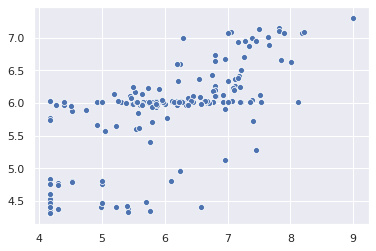

In [23]:
#Regresion model
#case2.1

random_state = 20
train_reg, test_reg = train_test_split(data_new, test_size = 0.25, random_state = random_state)
train_reg, test_reg = train.copy(), test.copy()

data_new_reg = [i for i in data_new['bin']]


x_train_reg = [f for f in train_reg['bin']]
x_test_reg = [f for f in test_reg['bin']]
y_train_reg = [a for a in train_reg['pec50']]
y_test_reg = [a for a in test_reg['pec50']]

rfr = RandomForestRegressor(n_estimators=101,max_depth=4, random_state=random_state)
rfr.fit(x_train_reg, y_train_reg)

y_pred = rfr.predict(x_test_reg)
sns.scatterplot(x=y_test_reg, y=y_pred)

y_pred = rfr.predict(data_new_reg)
data_new['pec50_new'] = y_pred

df = pd.DataFrame({'pec50':[], 'pec50_new':[]})
df['pec50'] = data_new['pec50']
df['pec50_new'] = data_new['pec50_new']
print("Table when you see old pec50 and new pec50")
display(df)


print("Regressor score:", rfr.score(x_test_reg, y_test_reg))

In [96]:
#create classification model after reggresion model
#case2.2s
def classification_after_regression(thre):
    random_state = 20


    #add new column
    data_new['category_new_reg'] = np.where(data_new['pec50_new']>=thre, 1, 0)
 

    #divided date for two sets: train and test
    train, test = train_test_split(data_new, test_size = 0.25, random_state = random_state)
    train, test = train.copy(), test.copy()
    x_train = np.asarray([x for x in train['bin']])
    x_test = np.asarray([x for x in test['bin']]) 
    y_train = np.asarray([y for y in train['category_new_reg']])
    y_test = np.asarray([y for y in test['category_new_reg']])

    #RandomForesrClassifier
    crf = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
    crf.fit(x_train,y_train)

    # prediction on test set
    crf_predict = crf.predict(x_test)

    #CLassification:
       #accuracy, spe, sen, MCC,
        #confusion matrices (true positive, true negative, false positive, false negative (TP, TN, FP, FN))
    
    #confusion_matrix
    #print("Confusion_matrix for test set:")
    conf_matrix = confusion_matrix(y_test, crf_predict)
   # print(conf_matrix)
    TN, FP, FN, TP = conf_matrix.ravel()
    d = {' ': ['actual+', 'actual-'], 'predicted+':[TP, FN], 'predicted-':[FP, TN]}
    df = pd.DataFrame(data=d)
    #print("\n")
    #print(df)
    #print("\n")

    #Accuracy
    #print("Accuracy:",metrics.accuracy_score(y_test, crf.predict(x_test)))
    #print("\n")
    #print("=== Classification Report ===")
    #print(classification_report(y_test, crf_predict))

    # Performance metrics
    errors = abs(crf_predict - y_test)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    #MCC
    MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    #put data for pandas data_out
    try:
        dda = {'threshold': [thre],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
          'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
        ddff = pd.DataFrame(data=dda)

        data_out_reg = data_out_reg.append(ddff, ignore_index = True)
        data_out_reg.drop_duplicates(keep='first', inplace=True)
    except:
        dda = {'threshold': [],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
          'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
        data_out_reg = pd.DataFrame(data=dda)
        dda = {'threshold': [thre],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
          'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
        ddff = pd.DataFrame(data=dda)

        data_out_reg = data_out_reg.append(ddff, ignore_index = True)
        data_out_reg.drop_duplicates(keep='first', inplace=True)



    y_score1 = crf.predict_proba(x_test)[:,1]
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
    #print('roc_auc_score for RandomForestClassification: ', round(roc_auc_score(y_test, y_score1),4))
    return data_out_reg
a1 = classification_after_regression(5)
a2 = classification_after_regression(5.5)
a3 = classification_after_regression(6)
a4 = classification_after_regression(6.5)
a5 = classification_after_regression(7)
frames = [ a1, a2, a3, a4, a5]
data_out_reg = pd.concat(frames)
data_out_reg.index = np.arange(len(data_out_reg))
display(data_out_reg)

threshold  Accuracy  Sensitiv.   Specif.       MCC  Positive pred  \
0        5.0  0.970370   0.959459  0.983607  0.940776       0.986111   
1        5.5  0.966667   0.944828  0.992000  0.934485       0.992754   
2        6.0  0.870370   0.722222  0.969136  0.734028       0.939759   
3        6.5  0.955556   0.538462  1.000000  0.716395       1.000000   
4        7.0  0.985185   0.700000  0.996154  0.775347       0.875000   

   Negative pred  False positive  False negative  
0       0.952381        0.016393        0.040541  
1       0.939394        0.008000        0.055172  
2       0.839572        0.030864        0.277778  
3       0.953125        0.000000        0.461538  
4       0.988550        0.003846        0.300000

In [97]:
data_out_reg.to_csv('data_out_reg_diferentthreshold_clasification_modelafter_reg.csv',  encoding='utf-8')

In [100]:
data_clas = pd.read_csv('/home/valeriia/bakalarka/bakalarka/data_out_diferent_threshold_clasification_model.csv')
print("Data for classifikation model(step 1)")
data_clas.head()

Data for classifikation model(step 1)


Unnamed: 0  threshold  Accuracy  Sensitiv.   Specif.       MCC  \
0           0        5.0  0.918519   0.923611  0.912698  0.836310   
1           1        5.5  0.870370   0.873016  0.868056  0.740154   
2           2        6.0  0.800000   0.478261  0.966292  0.542414   
3           3        6.5  0.803704   0.187500  0.995146  0.362823   
4           4        7.0  0.881481   0.179487  1.000000  0.397050   

   Positive pred  Negative pred  False positive  False negative  
0       0.923611       0.912698        0.087302        0.076389  
1       0.852713       0.886525        0.131944        0.126984  
2       0.880000       0.781818        0.033708        0.521739  
3       0.923077       0.797665        0.004854        0.812500  
4       1.000000       0.878327        0.000000        0.820513

In [98]:
data_clas_cros = pd.read_csv('/home/valeriia/bakalarka/bakalarka/vystup_Nsplits5_clasification_model.csv')
print("Data after croos validation for classification model (step1)")
data_clas_cros

Data after croos validation for classification model (step1)


Unnamed: 0  threshold  N_Split  Split  Accuracy  Sensitiv.   Specif.  \
0            0        5.0      5.0    0.0  0.907407   0.910714  0.903846   
1            1        5.0      5.0    1.0  0.902778   0.885965  0.921569   
2            2        5.0      5.0    2.0  0.893519   0.877358  0.909091   
3            3        5.0      5.0    3.0  0.939815   0.922330  0.955752   
4            4        5.0      5.0    4.0  0.912037   0.873684  0.942149   
5            5        5.5      5.0    0.0  0.865741   0.860000  0.870690   
6            6        5.5      5.0    1.0  0.865741   0.842105  0.884298   
7            7        5.5      5.0    2.0  0.828704   0.781609  0.860465   
8            8        5.5      5.0    3.0  0.921296   0.876404  0.952756   
9            9        5.5      5.0    4.0  0.893519   0.841463  0.925373   
10          10        6.0      5.0    0.0  0.787037   0.416667  0.972222   
11          11        6.0      5.0    1.0  0.814815   0.492754  0.965986   
12          12        6.0      5.0    2.0  0.824074   0.558824  0.945946   
13          13        6.0      5.0    3.0  0.800926   0.390625  0.973684   
14          14        6.0      5.0    4.0  0.814815   0.403226  0.980519   
15          15        6.5      5.0    0.0  0.805556   0.196078  0.993939   
16          16        6.5      5.0    1.0  0.819444   0.152174  1.000000   
17          17        6.5      5.0    2.0  0.810185   0.200000  0.993976   
18          18        6.5      5.0    3.0  0.870370   0.250000  0.994444   
19          19        6.5      5.0    4.0  0.856481   0.222222  0.983333   
20          20        7.0      5.0    0.0  0.884259   0.193548  1.000000   
21          21        7.0      5.0    1.0  0.888889   0.148148  0.994709   
22          22        7.0      5.0    2.0  0.875000   0.103448  0.994652   
23          23        7.0      5.0    3.0  0.939815   0.333333  0.994949   
24          24        7.0      5.0    4.0  0.907407   0.200000  0.979592   

         MCC  Positive pred  Negative pred  False positive  False negative  
0   0.814560       0.910714       0.903846        0.096154        0.089286  
1   0.806321       0.926606       0.878505        0.078431        0.114035  
2   0.787159       0.902913       0.884956        0.090909        0.122642  
3   0.879557       0.950000       0.931034        0.044248        0.077670  
4   0.821390       0.922222       0.904762        0.057851        0.126316  
5   0.730218       0.851485       0.878261        0.129310        0.140000  
6   0.727257       0.851064       0.877049        0.115702        0.157895  
7   0.643308       0.790698       0.853846        0.139535        0.218391  
8   0.837161       0.928571       0.916667        0.047244        0.123596  
9   0.772660       0.873418       0.905109        0.074627        0.158537  
10  0.503382       0.882353       0.769231        0.027778        0.583333  
11  0.556072       0.871795       0.802260        0.034014        0.507246  
12  0.572631       0.826087       0.823529        0.054054        0.441176  
13  0.487935       0.862069       0.791444        0.026316        0.609375  
14  0.516822       0.892857       0.803191        0.019481        0.596774  
15  0.367069       0.909091       0.800000        0.006061        0.803922  
16  0.351821       1.000000       0.813397        0.000000        0.847826  
17  0.372146       0.909091       0.804878        0.006024        0.800000  
18  0.433545       0.900000       0.868932        0.005556        0.750000  
19  0.348452       0.727273       0.863415        0.016667        0.777778  
20  0.412925       1.000000       0.880952        0.000000        0.806452  
21  0.314187       0.800000       0.890995        0.005291        0.851852  
22  0.248081       0.750000       0.877358        0.005348        0.896552  
23  0.512383       0.857143       0.942584        0.005051        0.666667  
24  0.275647       0.500000       0.923077        0.020408        0.800000

In [99]:
data_clas_reg = pd.read_csv('/home/valeriia/bakalarka/bakalarka/data_out_reg_diferentthreshold_clasification_modelafter_reg.csv')
print("Data classifikation(which i built after regresion model)(step 2)")
data_clas_reg

Data classifikation(which i built after regresion model)(step 2)


Unnamed: 0  threshold  Accuracy  Sensitiv.   Specif.       MCC  \
0           0        5.0  0.970370   0.959459  0.983607  0.940776   
1           1        5.5  0.966667   0.944828  0.992000  0.934485   
2           2        6.0  0.870370   0.722222  0.969136  0.734028   
3           3        6.5  0.955556   0.538462  1.000000  0.716395   
4           4        7.0  0.985185   0.700000  0.996154  0.775347   

   Positive pred  Negative pred  False positive  False negative  
0       0.986111       0.952381        0.016393        0.040541  
1       0.992754       0.939394        0.008000        0.055172  
2       0.939759       0.839572        0.030864        0.277778  
3       1.000000       0.953125        0.000000        0.461538  
4       0.875000       0.988550        0.003846        0.300000

In [35]:
#NEW KOD:
#end table

data = pd.read_csv('/home/valeriia/bakalarka/bakalarka/LXRb_ch25_curated_DW_2.csv')
# copy raw data
data_new_2 = data.copy()
data_new_2["Molecule"] = [Chem.MolFromSmiles(mol) for mol in data["smiles"]]

#colmun['Molecule'] invert to binary systems
data_new_2['bin'] = [np.array(AllChem.GetMorganFingerprintAsBitVect(i,2, nBits=1024)) for i in data_new_2['Molecule']]


In [57]:
pomoc = {'Case':[],'threshold': [],'Split':[],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[]}
data_out_end = pd.DataFrame(data=pomoc)

Case  threshold  Split  Accuracy  Sensitiv.   Specif.       MCC
0    1.0        5.0    1.0  0.902778   0.885965  0.921569  0.806321
1    1.0        5.0    2.0  0.893519   0.877358  0.909091  0.787159
2    1.0        5.0    3.0  0.939815   0.922330  0.955752  0.879557
3    1.0        5.0    4.0  0.912037   0.873684  0.942149  0.821390
4    2.2        5.0    0.0  0.981481   1.000000  0.962264  0.963587
5    2.2        5.0    1.0  0.944444   0.981308  0.908257  0.891401
6    2.2        5.0    2.0  0.976852   1.000000  0.955357  0.954743
7    2.2        5.0    3.0  0.949074   0.969697  0.931624  0.898803
8    2.2        5.0    4.0  0.939815   0.977778  0.912698  0.881086
9    1.0        5.5    1.0  0.865741   0.842105  0.884298  0.727257
10   1.0        5.5    2.0  0.828704   0.781609  0.860465  0.643308
11   1.0        5.5    3.0  0.921296   0.876404  0.952756  0.837161
12   1.0        5.5    4.0  0.893519   0.841463  0.925373  0.772660
13   2.2        5.5    0.0  0.958333   0.990566  0.927273  0.918666
14   2.2        5.5    1.0  0.958333   0.990476  0.927928  0.918680
15   2.2        5.5    2.0  0.962963   0.980198  0.947826  0.926430
16   2.2        5.5    3.0  0.972222   1.000000  0.950413  0.945491
17   2.2        5.5    4.0  0.953704   0.965909  0.945312  0.905452
18   1.0        6.0    1.0  0.814815   0.492754  0.965986  0.556072
19   1.0        6.0    2.0  0.824074   0.558824  0.945946  0.572631
20   1.0        6.0    3.0  0.800926   0.390625  0.973684  0.487935
21   1.0        6.0    4.0  0.814815   0.403226  0.980519  0.516822
22   2.2        6.0    0.0  0.916667   0.939394  0.906667  0.816109
23   2.2        6.0    1.0  0.902778   0.960000  0.895288  0.679373
24   2.2        6.0    2.0  0.907407   0.932432  0.894366  0.804884
25   2.2        6.0    3.0  0.944444   1.000000  0.938462  0.772789
26   2.2        6.0    4.0  0.949074   1.000000  0.943590  0.786912
27   1.0        6.5    1.0  0.819444   0.152174  1.000000  0.351821
28   1.0        6.5    2.0  0.810185   0.200000  0.993976  0.372146
29   1.0        6.5    3.0  0.870370   0.250000  0.994444  0.433545
30   1.0        6.5    4.0  0.856481   0.222222  0.983333  0.348452
31   2.2        6.5    0.0  0.962963   1.000000  0.960784  0.759257
32   2.2        6.5    1.0  0.962963   1.000000  0.961353  0.713408
33   2.2        6.5    2.0  0.962963   1.000000  0.960396  0.781768
34   2.2        6.5    3.0  0.976852   1.000000  0.975369  0.839305
35   2.2        6.5    4.0  0.972222   0.937500  0.975000  0.824451
36   1.0        7.0    1.0  0.888889   0.148148  0.994709  0.314187
37   1.0        7.0    2.0  0.875000   0.103448  0.994652  0.248081
38   1.0        7.0    3.0  0.939815   0.333333  0.994949  0.512383
39   1.0        7.0    4.0  0.907407   0.200000  0.979592  0.275647
40   2.2        7.0    0.0  0.990741   1.000000  0.990566  0.812636
41   2.2        7.0    1.0  0.976852   1.000000  0.976303  0.698679
42   2.2        7.0    2.0  0.990741   1.000000  0.990654  0.703795
43   2.2        7.0    3.0  0.995370   1.000000  0.995238  0.923613
44   2.2        7.0    4.0  0.995370   1.000000  0.995215  0.933174

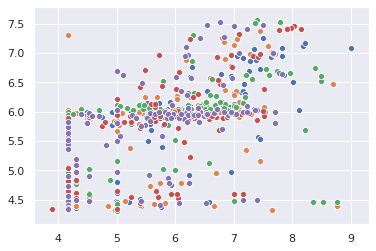

In [105]:
#END table of all model
def comparisons_of_all_models(thre):
    n_splits = 5
    random_state = 20
    data_new_2['number'] = data_new_2['chembl_id'].rank(method='min')
    lab_enc = preprocessing.LabelEncoder()
    data_new_2['number']= lab_enc.fit_transform(data_new_2['number'])
    #category_new is column where have convert category(inactive/active) to (0,1)
    data_new_2['category_new'] = np.where(data_new_2['pec50']>=thre, 1, 0)

    kf = KFold(n_splits = n_splits, shuffle=True, random_state=random_state)
    a = -1   
       
    for trains, tests in kf.split(data_new_2):
        a = a+1
        #print('Number of split:', a)
        train = data_new_2.iloc[trains]
        test = data_new_2.iloc[tests]
        #clasification, i used bin and category new columns   
        case = 1
        x_train = np.asarray([x for x in train['bin']])
        x_test = np.asarray([x for x in test['bin']]) 
        y_train = np.asarray([y for y in train['category_new']])
        y_test = np.asarray([y for y in test['category_new']])
    
        rfc = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
        rfc.fit(x_train,y_train)
        rfc_predict = rfc.predict(x_test)
        conf_matrix = confusion_matrix(y_test, rfc_predict)
        TN, FP, FN, TP = conf_matrix.ravel()
    
        accur = metrics.accuracy_score(y_test, rfc.predict(x_test))
        #print(accur)
    
        # Sensitivity
        TPR = TP/(TP+FN)
        # Specificity 
        TNR = TN/(TN+FP)
        #MCC
        MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
    
        try:
            pomoc = {'Case':[case],'threshold': [thre],'Split':[a],'Accuracy':[accur], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC]}
            df_table = pd.DataFrame(data=pomoc)

            data_out_end = data_out_end.append(df_table, ignore_index = True)
            data_out_end.drop_duplicates(keep='first', inplace=True)
        except:
            pomoc = {'Case':[],'threshold': [],'Split':[],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[]}
            data_out_end = pd.DataFrame(data=pomoc)

        

        #regresion i used bin and pec50  ?????
        case = 2.1
        x_train_reg = [f for f in train['bin']]
        x_test_reg = [f for f in test['bin']]
        y_train_reg = [a for a in train['pec50']]
        y_test_reg = [a for a in test['pec50']]
        data_new_reg = [i for i in data_new_2['bin']]
        rfr = RandomForestRegressor(n_estimators=101,max_depth=4, random_state=random_state)
        rfr.fit(x_train_reg, y_train_reg)
        y_pred = rfr.predict(x_test_reg)
        sns.scatterplot(x=y_test_reg, y=y_pred)

        y_pred = rfr.predict(data_new_reg)
        data_new_2['pec50_new'] = y_pred
    
    
      
        #classification after regresion i used bin and category_new_reg
        case = 2.2
        data_new_2['category_new_reg'] = np.where(data_new_2['pec50_new']>=thre, 1, 0)
        train = data_new_2.iloc[trains]
        test = data_new_2.iloc[tests]
    
        x_train_cl = np.asarray([x for x in train['bin']])
        x_test_cl = np.asarray([x for x in test['bin']]) 
        y_train_cl = np.asarray([y for y in train['category_new_reg']])
        y_test_cl = np.asarray([y for y in test['category_new_reg']])
    
        rfc_reg = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
        rfc_reg.fit(x_train_cl,y_train_cl)
        rfc_reg_predict = rfc_reg.predict(x_test_cl)
        conf_matrix = confusion_matrix(rfc_reg.predict(x_test_cl), y_test_cl)
        #print(conf_matrix)
    
    
        accur = metrics.accuracy_score(y_test_cl, rfc_reg.predict(x_test_cl))
       # print(accur)
        if(accur == 1):
            TPR = 1
            TNR = 1
            MCC = 1
        else:
            TN, FP, FN, TP = conf_matrix.ravel()
            # Sensitivity
            TPR = TP/(TP+FN)
            # Specificity 
            TNR = TN/(TN+FP)
            #MCC
            MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
    
        try:
            pomoc = {'Case':[case],'threshold': [thre],'Split':[a],'Accuracy':[accur], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC]}
            df_table = pd.DataFrame(data=pomoc)

            data_out_end = data_out_end.append(df_table, ignore_index = True)
            data_out_end.drop_duplicates(keep='first', inplace=True)
        except:
            pomoc = {'Case':[],'threshold': [],'Split':[],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[]}
            data_out_end = pd.DataFrame(data=pomoc)
            
    
        data_out_end = data_out_end.sort_values(by=['Case', 'threshold', 'Split'])
    #display(data_out_end)
    return data_out_end
    #display(data_out_end)

a1 = comparisons_of_all_models(5)
a2 = comparisons_of_all_models(5.5)
a3 = comparisons_of_all_models(6)
a4 = comparisons_of_all_models(6.5)
a5 = comparisons_of_all_models(7)
frames = [ a1, a2, a3, a4, a5]
result = pd.concat(frames)
result.index = np.arange(len(result))
display(result)

In [106]:
result.to_csv('data_out_end.csv')